### Monte Carlo Integration

We already saw Monte Carlo integreaton when we computed $\pi/4$ by computing the area of the unit quarter-circle.

Here is the code:

In [1]:
import random
N = 10000000

count = 0  #count will store the number of random points
           #that fell within the unit circle

for i in range(N):
    x, y = random.random(), random.random()
    if x**2 + y**2 < 1: #sqrt(1-x**2) < y
    
        count += 1
    
print(4.0*count/N)

3.140484


Note that another way to look at what we did was to say that we were computing $\int_{0}^{1} \sqrt{1-x^2} dx$: we wanted to compute the area under the curve defined by $x^2+y^2 = 1$ for $x > 0, y > 0$. We did that by computing the proportion of the area of the unit square occupied by the area under the curve.

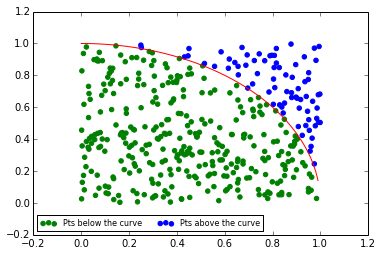

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def f(x):
    return np.sqrt(1-x**2)
N = 400
x = np.arange(0, 1, 0.01)
y = f(x)
x_rand = np.random.random(N)
y_rand = np.random.random(N)

ind_below = np.where(y_rand < f(x_rand))
ind_above = np.where(y_rand >= f(x_rand))

pts_below = plt.scatter(x_rand[ind_below], y_rand[ind_below], color = "green")
pts_above = plt.scatter(x_rand[ind_above], y_rand[ind_above], color = "blue")
plt.plot(x, y, color = "red")

plt.legend((pts_below, pts_above),
           ('Pts below the curve', 'Pts above the curve'),
           loc='lower left',
           ncol=3,
           fontsize=8)

The red curve is the unit qaurter circle, and also the curve $y = \sqrt{1-x^2}$.

We can generalize this approach to curves other than $y = \sqrt{1-x^2}$. The idea is this: For an arbitrary curve, find the rectangle that contains it, generate random point in that rectangle, and figure out how many of the random points fall under the curve.

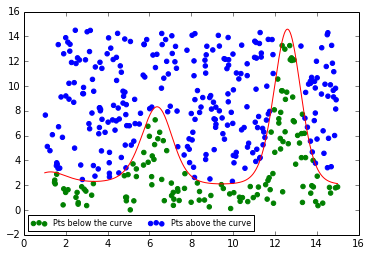

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
N = 400
x0 = 1
x1 = 15
def f(x):
    return x**np.cos(x)+2

x = np.arange(1, 15, 0.01)
y = f(x)
fmax = max(y)
x_rand = x0 + (x1 - x0)*np.random.random(N)
y_rand = np.random.random(N)*fmax

ind_below = np.where(y_rand < f(x_rand))
ind_above = np.where(y_rand >= f(x_rand))

pts_below = plt.scatter(x_rand[ind_below], y_rand[ind_below], color = "green")
pts_above = plt.scatter(x_rand[ind_above], y_rand[ind_above], color = "blue")
plt.plot(x, y, color = "red")

plt.legend((pts_below, pts_above),
           ('Pts below the curve', 'Pts above the curve'),
           loc='lower left',
           ncol=3,
           fontsize=8)

Whe computing $\int_{x_0}^{x_1} f(x) dx$, we want to find the rectangle in which to generate random points. A suitable rectangle can be found by finding $f_{max} = \max_{x_0\leq x\leq x_1} f(x)$. The rectangle would then be $[x_0, x_1]\times [0, f_{max}]$.

We can then proceed as before: generate random points inside the rectangle, compute the proportion of points that are found under the curve to the total number of random points generated inside the rectangle, and then multiply that proportion by the area of the rectangle to get the area under the curve (i.e., the integral.)

### Some numpy preliminaries

A convenient thing about NumPy arrays (which we saw in the Gaussian elimination lab) is that one can multiply them by constants, add them to each other, etc., and have the operations be *elementwise*. For example:

In [4]:
import numpy as np
a1 = np.array([1, 2, 3])
a1 * 2

array([2, 4, 6])

In [5]:
a1 + np.array([5, 4, 10])

array([ 6,  6, 13])

In [6]:
a1 + 5

array([6, 7, 8])

Note that none of this would work with Python lists. This all still applies if we pass the array as an argument to a function:

In [7]:
def inv_x(x):
    return 1.0/x

x = np.array([4, 10, 2])
inv_x(x)

array([ 0.25,  0.1 ,  0.5 ])

(Note that if `x` were a list, we would have an error, since you cannot divide `1` by a list).

To obtain an array of random number between 0 and 1, we can use

In [8]:
N = 5
random_arr = np.random.random(5)
random_arr

array([ 0.74844996,  0.28937055,  0.81647386,  0.82236961,  0.58634638])

Another convenient thing about array is that we can access them at multiple indices simultaneously using an index array. Suppose we want to access the 2nd and 3rd elements of `random_arr` above. We can use: 

In [9]:
inds = np.array([2, 3])
random_arr[inds]


array([ 0.81647386,  0.82236961])

Finally, it is convenient to use the `np.where` operator to find the indices of values that have some properties. For example, we can find all the indices of values above 0.5 in `random_arr` using

In [10]:
np.where(random_arr >= 0.5)

(array([0, 2, 3, 4]),)

Note the arguement to `np.where` is an array of Booleans.

In [11]:
random_arr >= 0.5

array([ True, False,  True,  True,  True], dtype=bool)

Finally, `np.arange` is somewhat analoguous to `range`. For example, the following gives an array of values between 5 and 7, not including 7, that are being incremented by `0.3`:

In [12]:
np.arange(5, 7, 0.3)

array([ 5. ,  5.3,  5.6,  5.9,  6.2,  6.5,  6.8])

### Computing definite integrals with Monte Carlo Integration

We are now ready to write a function that will approximate the definite integral of any non-negative continous function:

In [13]:
import numpy as np
import matplotlib.pyplot as plt
def definite_integral_show(f, x0, x1, N):
    """Approximate the definite integral of f(x)dx between x0 and x1 using
    N random points
    
    Arguments:
    f -- a function of one real variable, must be nonnegative on [x0, x1]
    N -- the number of random points to use
    
    
    """
    #First, let's compute fmax. We do that by evaluating f(x) on a grid
    #of points between x0 and x1
    #This assumes that f is generally smooth. If it's not, we're in trouble!
    x = np.arange(x0, x1, 0.01)
    y = f(x)
    f_max = max(y)
    
    
    #Now, let's generate the random points. The x's should be between
    #x0 and x1, so we first create points beterrm 0 and (x1-x0), and 
    #then add x0
    #The y's should be between 0 and fmax
    #
    #                  0...(x1-x0)
    x_rand = x0 + np.random.random(N)*(x1-x0)
    y_rand = 0 +  np.random.random(N)*f_max
    
    
    
    #Now, let's find the indices of the poitns above and below
    #the curve. That is, for points below the curve, let's find
    #   i s.t. y_rand[i] < f(x_rand)[i]
    #And for points above the curve, find
    #   i s.t. y_rand[i] >= f(x_rand)[i]
    ind_below = np.where(y_rand < f(x_rand))
    ind_above = np.where(y_rand >= f(x_rand))
    
    
    #Finally, let's display the results
    plt.plot(x, y, color = "red")
    plt.scatter(x_rand[ind_below], y_rand[ind_below], color = "green")
    plt.scatter(x_rand[ind_above], y_rand[ind_above], color = "blue")
    plt.legend((pts_below, pts_above),
           ('Pts below the curve', 'Pts above the curve'),
           loc='lower left',
           ncol=3,
           fontsize=8)
    
    print("Number of pts above the curve:", len(ind_above[0]))
    print("Number of pts below the curve:", len(ind_below[0]))
    print("N. below/N.total:", len(ind_below[0])/N)
    print("Rectangle area:", f_max*(x1-x0))
    print("Area under the curve:", f_max*(x1-x0)*len(ind_below[0])/N)

We can define and then plug in any function to `definite_integral_show()`. Let's try this with the example we already saw:

In [14]:
def f1(x):
    '''Return sqrt(1-x**2). If x is an array, perform the operation
    elementwise (whence the np.sqrt)'''
    return np.sqrt(1-x**2)

('Number of pts above the curve:', 47)
('Number of pts below the curve:', 153)
('N. below/N.total:', 0)
('Rectangle area:', 1.0)
('Area under the curve:', 0.76500000000000001)


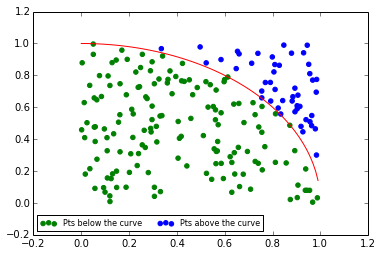

In [15]:
definite_integral_show(f1, 0, 1, 200)

Let's now define another function:

('Number of pts above the curve:', 707)
('Number of pts below the curve:', 293)
('N. below/N.total:', 0)
('Rectangle area:', 204.14747224287382)
('Area under the curve:', 59.815209367162034)


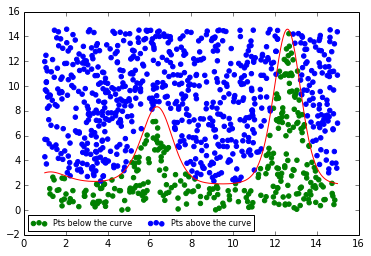

In [16]:
def g(x):
    return x**np.cos(x) + 2   

definite_integral_show(g, 1, 15, 1000)

### Computing $\log(x)$ using Monte Carlo integration

In Calculus, you saw that $\log(x) = \int_{1}^{x} 1/x dx$ by definition.

This is pretty easy to derive by defining $\exp(x)$ to be the function such that $\exp'(x) = \exp(x)$ (Note that this causes some issues: in particular, if we're using this definition, it needs to be proved that such a function exists -- that's why in Calculus, this route is not taken). By the Inverse Function Theorem, since $\log(y) = \exp^{-1}(y)$, 

$$\exp^{-1{'}}(exp(y)) = 1/\exp'(y) = 1/\exp(y)$$. 


Since $\log(y) = \exp^{-1}(t)$, we can substitute $t = \exp(y)$ to get $\log'(t) = 1/t$. 

Let's try to compute $\log(5)$:

('Number of pts above the curve:', 61)
('Number of pts below the curve:', 39)
('N. below/N.total:', 0)
('Rectangle area:', 4.0)
('Area under the curve:', 1.5600000000000001)


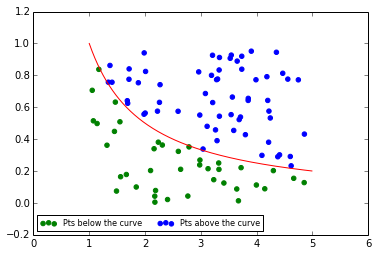

In [17]:
def inv_x(x):
    return 1.0/x

definite_integral_show(inv_x, 1, 5, 100)

With more points:

('Number of pts above the curve:', 591)
('Number of pts below the curve:', 409)
('N. below/N.total:', 0)
('Rectangle area:', 4.0)
('Area under the curve:', 1.6359999999999999)


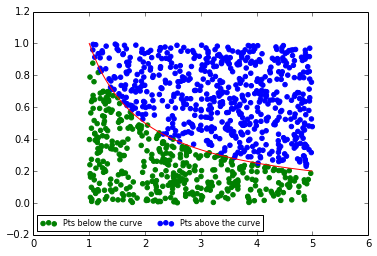

In [18]:
definite_integral_show(inv_x, 1, 5, 1000)

('Number of pts above the curve:', 59583)
('Number of pts below the curve:', 40417)
('N. below/N.total:', 0)
('Rectangle area:', 4.0)
('Area under the curve:', 1.6166799999999999)


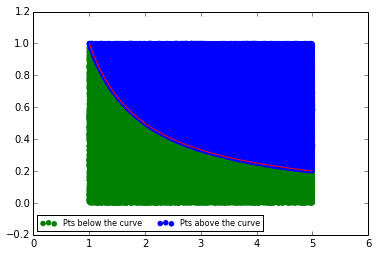

In [19]:
definite_integral_show(inv_x, 1, 5, 100000)

The actual value is:

In [20]:
np.log(5)

1.6094379124341003